###  Classification Targets

Target - the target is an ordinal variable indicating groups of income levels.

1 = extreme poverty \
2 = moderate poverty \
3 = vulnerable households \
4 = non vulnerable households


https://www.kaggle.com/competitions/costa-rican-household-poverty-prediction/data

### Setup

In [133]:
%pip install -r ../requirements.txt -q

Note: you may need to restart the kernel to use updated packages.


### Data Preparation

In [21]:
import pandas as pd
import numpy as np
from plotnine import *
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [6]:
data_dir = '../data/'
test_csv = data_dir + 'test.csv'
train_csv = data_dir + 'train.csv'
prediction_column = "Target"

### Data Preparation

In [121]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

def preprocess(data):
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean'))
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ])

    numeric_features = data.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = data.select_dtypes(include=['object']).columns

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    return preprocessor.fit_transform(data)

def prepare(csv_path = None, data = None):
    if csv_path is None and data is None:
        raise ValueError("Either csv_path or data must be provided")
    if csv_path is not None and data is not None:
        raise ValueError("Only one of csv_path or data must be provided")
    raw_data = None
    if csv_path is not None:
        raw_data = pd.read_csv(csv_path)
    else:
        raw_data = data  
    return preprocess(raw_data)

<Axes: >

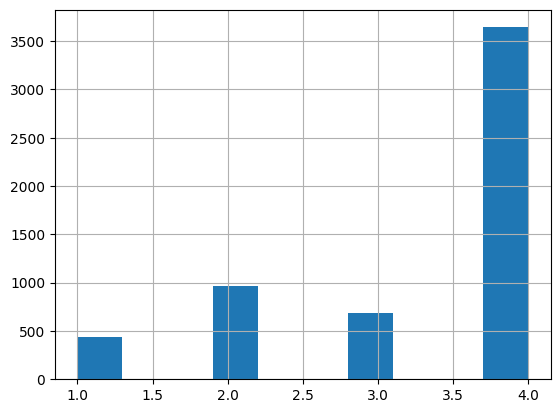

In [130]:
data = prepare(csv_path=train_csv)
target = pd.read_csv(train_csv)[prediction_column]
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.4, random_state=42)
y_train.hist()

### Submission

In [59]:
def export_submission(df):
    df.to_csv('submission.csv', index=False)

### Data Overview

### Sampling

In [142]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler

def oversample(X, y):
    ros = RandomOverSampler(random_state=0)
    return ros.fit_resample(X, y)

def undersample(X, y):
    ros = RandomUnderSampler(random_state=0)
    return ros.fit_resample(X, y)

def smotsample(X, y):
    ros = SMOTETomek(random_state=0)
    return ros.fit_resample(X, y)

<Axes: >

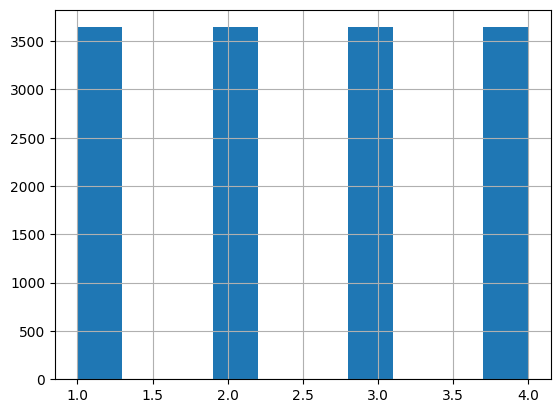

In [139]:
oversampled_X, oversampled_y = oversample(X_train, y_train)
oversampled_y.hist()

<Axes: >

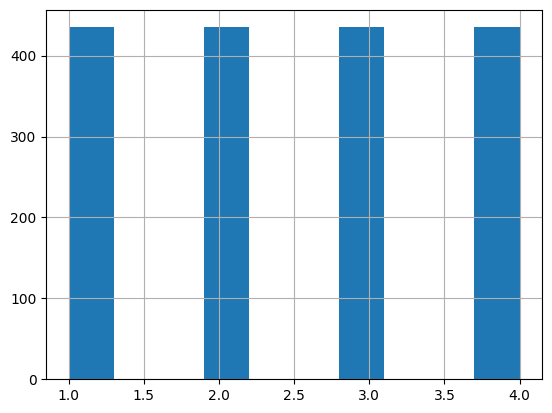

In [140]:
undersampled_X, undersampled_y = undersample(X_train, y_train)
undersampled_y.hist()

In [143]:
smotsampled_X, smotsampled_y = smotsample(X_train, y_train)
smotsampled_y.hist()

## Ensemble learning

### Shared Code

In [124]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

def train_model(model, train, test_size=0.2, param_grid = None):
    # X = train
    # y = train[prediction_column]

    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    if param_grid is not None:
        model = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
        
    model.fit(X_train, y_train)
    accuracy = accuracy_score(y_test, model.predict(X_test))
    return model, accuracy

def important_features(trained_model):
    columns = train[:]
    columns = columns.drop(prediction_column, axis=1)
    columns = columns.columns
    if trained_model.__class__ == GridSearchCV:
        trained_model = trained_model.best_estimator_
        
    feature_importance = pd.DataFrame(trained_model.feature_importances_,
                                    index = columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
    return feature_importance

### AdaBoost

In [131]:
ada_boost_param_grid = {
    # run this when you have time
    # 'learning_rate': [0.01, 0.1, 0.5],
    # 'base_estimator__max_depth': [3, 5, 7],
    # 'base_estimator__min_samples_leaf': [5, 10, 20]

    'learning_rate': [0.01],
    'estimator__max_depth': [3],
    'estimator__min_samples_leaf': [5, 10]
}

ada_boost_model, training_accuracy = train_model(AdaBoostClassifier(estimator=DecisionTreeClassifier()), X_train, param_grid=ada_boost_param_grid)
print(f"AdaBoost training accuracy: {training_accuracy}")


AdaBoost training accuracy: 1.0


In [126]:
ada_boost_model

GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier()),
             param_grid={'estimator__max_depth': [3],
                         'estimator__min_samples_leaf': [5, 10],
                         'learning_rate': [0.01]},
             scoring='accuracy')

In [39]:
ada_boost_model.best_params_

{'estimator__max_depth': 3,
 'estimator__min_samples_leaf': 5,
 'learning_rate': 0.01}

In [127]:
important_features(ada_boost_model)

AttributeError: 'csr_matrix' object has no attribute 'drop'

### Gradient Boosting

In [128]:
gradient_boost_param_grid = {
    # Run this at before going to sleep
    # 'learning_rate': [0.01, 0.1, 0.5],
    # 'max_depth': [3, 5, 7],
    # 'min_samples_leaf': [5, 10, 20]

    'learning_rate': [0.1],
    'max_depth': [3],
    'min_samples_leaf': [5]
}

gradient_boost_model, training_accuracy = train_model(GradientBoostingClassifier(), train, param_grid=gradient_boost_param_grid)
print(f"GradientBoost training accuracy: {training_accuracy}")


KeyboardInterrupt: 

In [52]:
gradient_boost_model.__class__

sklearn.model_selection._search.GridSearchCV

In [53]:
important_features(gradient_boost_model)

,importance
SQBdependency,0.112112
meaneduc,0.108947
SQBmeaned,0.094643
SQBhogar_nin,0.052052
qmobilephone,0.042270
...,...
instlevel2,0.000000
instlevel4,0.000000
instlevel9,0.000000
instlevel8,0.000000


### XGBoost

In [72]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

def train_xgboost_model(train, xgb_params, test_size=0.2):
    train = train[:]
    X = train.drop(prediction_column, axis=1)
    y = train[prediction_column]
    

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
    train_labels = le.fit_transform(y_train)
    val_labels = le.transform(y_test)

    dtrain = xgb.DMatrix(X_train, label=train_labels, enable_categorical=True)
    dval = xgb.DMatrix(X_test, label=val_labels, enable_categorical=True)
    eval_set = [(dtrain, 'train'), (dval, 'eval')]
    
    xgb_model = xgb.train(
        xgb_params, 
        dtrain, 
        num_boost_round=1000, 
        evals=eval_set, 
        early_stopping_rounds=10, 
        verbose_eval=False
    )
    accuracy = accuracy_score(val_labels, xgb_model.predict(dval))

    return xgb_model, accuracy

def xgb_feature_importance(xgb_model):
    feature_importance = xgb_model.get_score(importance_type='weight')
    feature_importance_df = pd.DataFrame({
        'Feature': list(feature_importance.keys()),
        'Importance': list(feature_importance.values())
    })
    feature_importance_df.sort_values(by='Importance', ascending=False).head(5)
    return feature_importance_df

In [73]:
xgb_params = {
    "objective": "multi:softmax", 
    "num_class": 4,
    "eval_metric": "merror"
}

xgb_model, training_accuracy = train_xgboost_model(train, xgb_params)
print(f"XGBoost training accuracy: {training_accuracy}")

XGBoost training accuracy: 0.9257322175732218


In [74]:
feature_importance_df = xgb_feature_importance(xgb_model)
feature_importance_df

,Feature,Importance
0,v2a1,750.0
1,hacdor,33.0
2,rooms,838.0
3,hacapo,14.0
4,v14a,12.0
...,...,...
117,area1,290.0
118,age,1131.0
119,SQBedjefe,1046.0
120,SQBdependency,799.0


## Tasks
- ✅ A working setup for Ensemble learning with AdaBoost, Gradient Boosting and XGBoost
- ✅ Feature importance for the different models
- ✅ Compare the different models accuracy
- ❌ Add different data preprocessing methods
- ❌ Balance dataset by undersampling, and possibly oversampling
- ❌ Find optimum parameter for the different models